In [2]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [3]:
paths = []
labels = []

for dirname, _, filenames in os.walk('emotional_speech_set_data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1];
        label = label.split('.')[0]
        labels.append(label.lower())

In [4]:
import librosa
import numpy as np

n_mels = 128  # Adjust this value as needed
fmin = 0  # Adjust this value as needed
fmax = 8000  # Adjust this value as needed
 

spectrograms = [] 

for audio_path in paths:
    try:
        data, sample_rate = librosa.load(audio_path, duration=3, offset=0.5)
        spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=4096, n_mels=n_mels, fmin=fmin, fmax=fmax)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        spectrograms.append(spectrogram)
               
            
    except Exception as e:
        print(f"Error processing file: {audio_path}, {e}")



In [5]:
import numpy as np


max_columns = max(s.shape[1] for s in spectrograms)

padded_spectrograms = [np.pad(arr, ((0, 0), (0, max_columns - arr.shape[1])), mode='constant') for arr in spectrograms]

spectrograms = np.array(padded_spectrograms)

print(spectrograms.shape)


(5600, 128, 108)


In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to numerical class indices
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
num_classes = len(label_encoder.classes_)
print(num_classes)
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

X_train = np.expand_dims(x_train, axis=-1)
X_test = np.expand_dims(x_test, axis=-1)
X_train.shape, y_train_encoded.shape, X_test.shape, y_test_encoded.shape

(4480, 128, 108)
(1120, 128, 108)
7


((4480, 128, 108, 1), (4480, 7), (1120, 128, 108, 1), (1120, 7))

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape, BatchNormalization

def build_train_evaluate_cnn_lstm_model(X_train, y_train_encoded, X_test, y_test_encoded, num_classes, batch_size=32, epochs=25):
    # Build the CNN + LSTM model with regularization and Batch Normalization
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Add Batch Normalization after Dense

    # Reshape the output of the Flatten layer to add a time step dimension
    model.add(Reshape((1, -1)))

    # Add the first LSTM layer with 128 units
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Add Batch Normalization after LSTM

    # Add the second LSTM layer with 64 units
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Add Batch Normalization after LSTM

    model.add(Dense(num_classes, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train_encoded, batch_size=batch_size, epochs=25, validation_split=0.2)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test[..., np.newaxis], y_test_encoded)
    print(f'Test accuracy: {accuracy}')

    train_predict = model.predict(X_train[..., np.newaxis])
    test_predict = model.predict(X_test[..., np.newaxis
                                       ])
    train_rmse = np.sqrt(np.mean((train_predict - y_train_encoded)**2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test_encoded)**2))
    print("Train RMSE: ", train_rmse)
    print("Test RMSE: ", test_rmse)
    return model, history

Epoch 1/25
112/112 [==============================] - 91s 618ms/step - loss: 1.8442 - accuracy: 0.3211 - val_loss: 1.7384 - val_accuracy: 0.5324
Epoch 2/25
112/112 [==============================] - 70s 622ms/step - loss: 1.2337 - accuracy: 0.5215 - val_loss: 1.5100 - val_accuracy: 0.2846
Epoch 3/25
112/112 [==============================] - 116s 1s/step - loss: 0.9298 - accuracy: 0.6482 - val_loss: 1.0544 - val_accuracy: 0.5469
Epoch 4/25
112/112 [==============================] - 121s 1s/step - loss: 0.7604 - accuracy: 0.7319 - val_loss: 1.0996 - val_accuracy: 0.5446
Epoch 5/25
112/112 [==============================] - 117s 1s/step - loss: 0.6108 - accuracy: 0.8005 - val_loss: 0.9919 - val_accuracy: 0.5614
Epoch 6/25
112/112 [==============================] - 121s 1s/step - loss: 0.4608 - accuracy: 0.8544 - val_loss: 0.5999 - val_accuracy: 0.7288
Epoch 7/25
112/112 [==============================] - 122s 1s/step - loss: 0.3678 - accuracy: 0.8984 - val_loss: 0.1178 - val_accuracy: 0.

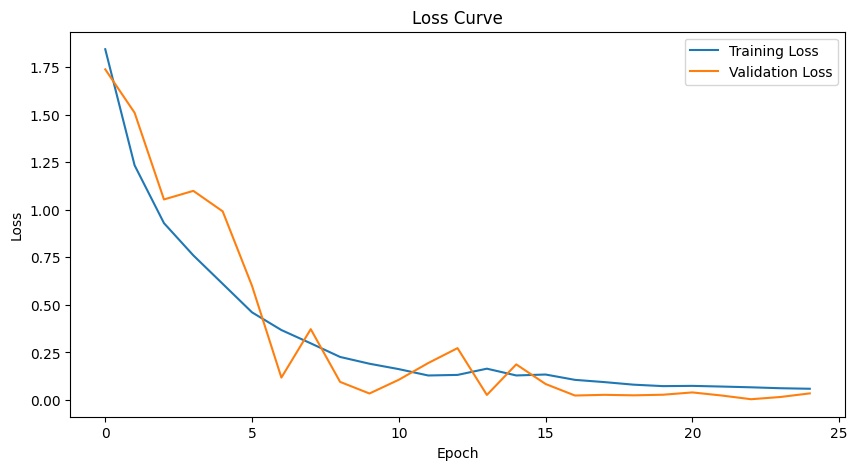

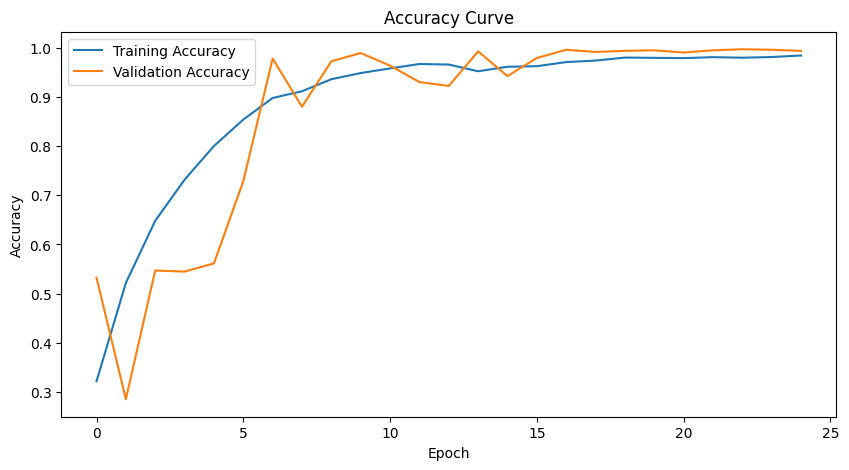

In [13]:
# Plot the loss and accuracy curves
def plot_loss_and_accuracy(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()
# already have X_train, y_train_encoded, X_test, y_test_encoded, num_classes, and the model defined
model, history = build_train_evaluate_cnn_lstm_model(X_train, y_train_encoded, X_test, y_test_encoded, num_classes)
plot_loss_and_accuracy(history)

35/35 [==============================] - 6s 154ms/step
[[176   0   0   0   0   0   0]
 [  0 153   0   0   0   0   0]
 [  0   0 149   0   0   0   0]
 [  0   0   0 143   0   0   0]
 [  0   0   0   0 175   0   0]
 [  0   1   0   0   0 164   0]
 [  0   0   0   0   0   0 159]]


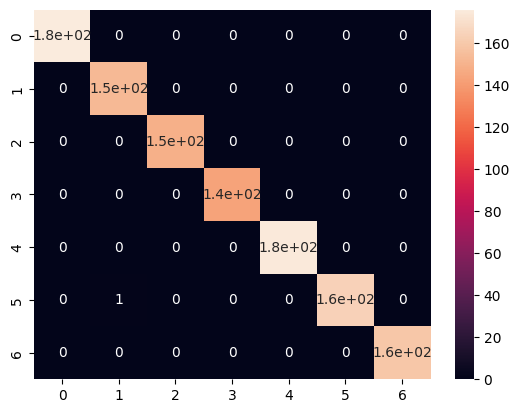

In [9]:
y_pred = model.predict(X_test)

import seaborn as sns
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print(confusion_matrix)

ax = sns.heatmap(confusion_matrix, annot=True)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 106, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 53, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 53, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 63, 53, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 51, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 25, 64)       0

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test_labels, y_pred_labels, average='macro')  
macro_recall = recall_score(y_test_labels, y_pred_labels, average='macro')  
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

micro_precision = precision_score(y_test_labels, y_pred_labels, average='micro')  
micro_recall = recall_score(y_test_labels, y_pred_labels, average='micro')  
micro_f1 = f1_score(y_test_labels, y_pred_labels, average='micro')

print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 score:", macro_f1)

print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)
print("Micro F1 score:", micro_f1)

Macro Precision: 0.9990723562152134
Macro Recall: 0.9991341991341992
Macro F1 score: 0.9991004510474228
Micro Precision: 0.9991071428571429
Micro Recall: 0.9991071428571429
Micro F1 score: 0.9991071428571429
